In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba
from sklearn.cluster import KMeans

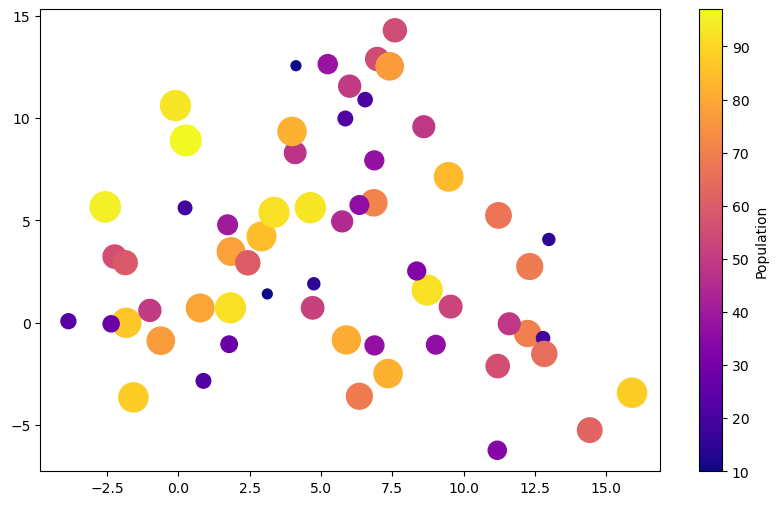

In [28]:
centers = np.array([[0, 0], [10, 0], [5, 10]])

# Générer les points à l'intérieur de chaque cluster
points_per_cluster = 20
points = []

for center in centers:
    # Générer des points aléatoires autour du centre du cluster
    cluster_points = np.random.normal(loc=center, scale=3, size=(points_per_cluster, 2))
    points.extend(cluster_points)

points = np.array(points)
xp = points[:, 0]
yp = points[:, 1]


population = np.random.randint(10, 101, size = 3*20)
size = population*5
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')



In [29]:
Hs = 1
N = 18
n_clusters = 3
Is = 10
Imin = 0.1
ImaxSol = Imin*2

I_min_sol = 5
p = 100

In [30]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [31]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)

@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    return 0

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)





In [32]:
P = np.vstack((xp, yp)).T

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

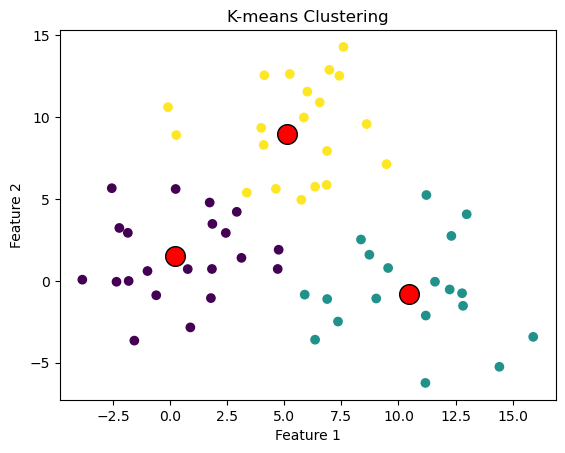

In [33]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [34]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]
centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))



t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

/Users/adammesbahi/anaconda3/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/g7/ns5n8gvs4pn0vkl_qlxflbkc0000gn/T/ipykernel_73943/3802933048.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


temps :  0.9989912509918213
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0
       x: [ 1.340e+00  4.855e-01 ...  6.873e+00  6.681e+00]
     nit: 95
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 3692
    njev: 95
Résultat de l'optimisation: 0
Valeurs optimales des variables: [ 1.33959786  0.48549152 12.99674787  3.04783872  2.18473267  4.01266381
 -2.27664511 -0.60657904 12.81341777 -0.86515455 -0.87846507  2.82072391
 -4.0943739   5.41238841  8.91409814  1.8877383   6.91235734 12.31440453
  5.70914688 -0.81169339 10.65351548  4.84490657  3.74371988  9.01188898
 -2.87918009  5.67272416 12.65358165 -2.39318458  4.06280901  5.5570944
 -1.02549324  0.24621833  6.96567758 -3.17407869  6.87265791  6.68125294]
Valeur de la contrainte 1 :  0.7999998602459977


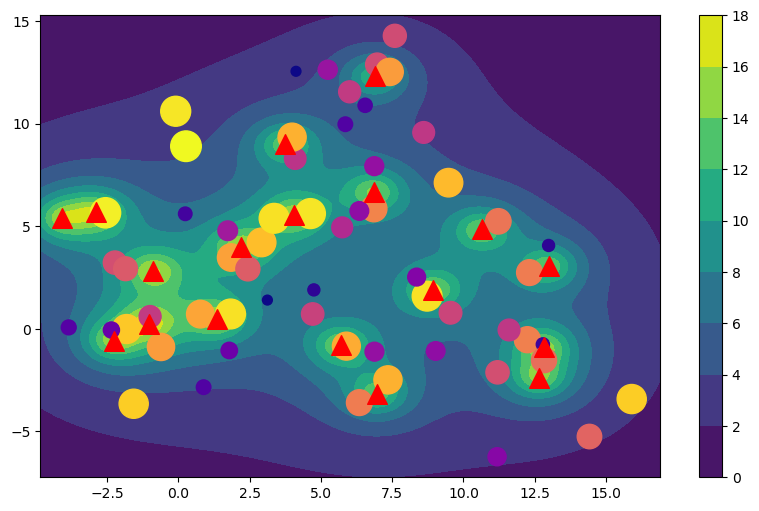

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")


Voila donc on a repris exactement le même problème que dans S3-3 et maintenant on va refaire un nouveau problème comme dans S3-4 mais les conditions initiales seront enft les positions des satellites qu'on vient de trouver et on va également mettre les intensités à 10 au départ

In [44]:
@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    somme = 0
    for i in range(N) : 
        somme += x[2*N+i]
    return somme
  

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += x[2*N+i]/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)



def contrainte_intensity(x) : 
    return x[2*N:]



In [45]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

centers = centers.reshape(n_clusters*2)
x0 = solution_position
x0_intensity = np.ones(N)*10
x0 = np.hstack((x0, x0_intensity))
print(x0)
        
myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
myc4 = NonlinearConstraint(contrainte_intensity, 0, 20)
contraintes = [myc1, myc4]




t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", contrainte_intensity(resultat.x))

[ 1.33959786  0.48549152 12.99674787  3.04783872  2.18473267  4.01266381
 -2.27664511 -0.60657904 12.81341777 -0.86515455 -0.87846507  2.82072391
 -4.0943739   5.41238841  8.91409814  1.8877383   6.91235734 12.31440453
  5.70914688 -0.81169339 10.65351548  4.84490657  3.74371988  9.01188898
 -2.87918009  5.67272416 12.65358165 -2.39318458  4.06280901  5.5570944
 -1.02549324  0.24621833  6.96567758 -3.17407869  6.87265791  6.68125294
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.        ]


/Users/adammesbahi/anaconda3/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/g7/ns5n8gvs4pn0vkl_qlxflbkc0000gn/T/ipykernel_73943/374032613.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


temps :  0.9266259670257568
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 136.6135461695505
       x: [ 1.485e+00  7.561e-01 ...  1.136e+01  5.662e+00]
     nit: 73
     jac: [ 0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00]
    nfev: 4074
    njev: 73
Résultat de l'optimisation: 136.6135461695505
Valeurs optimales des variables: [ 1.48450855  0.75605426 12.26120266  2.7387391   2.39090181  3.78932842
 -1.62871027 -0.05686979 12.31564826 -1.09595461 -1.97856466  3.06072411
 -2.52957192  5.60418509  8.76756522  1.526099    6.95750011 13.0901122
  5.66025709 -0.49340228 11.20122574  5.19782303  4.11511134  9.34042337
 -2.52952217  5.60421592 11.29552351 -1.95601328  4.03564998  5.42707327
 -0.70111721 -0.6900078   6.8458856  -2.92046009  6.78124122  6.0096394
  9.45992165  5.89691291  8.02420783  7.47303056  8.99314014  3.98750105
  4.75280197  8.65049179 16.45889742  7.63734128  5.88934438  8.15772456
  5.22896134  2.61438221 11.56888077  4.79540316

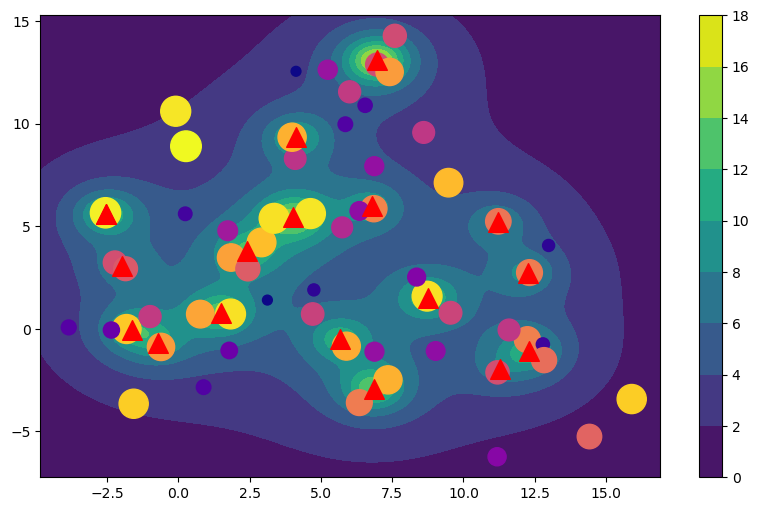

In [46]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += sol[2*N+i]/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")


Et la dinguerie, on a enfait une intensité totale utilisée de 136 alors qu'avant, on avait une intensité de 180, toujours avec 18 satellites et notre condition d'avoir 80 prct est bien toujours respectée!!